In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error

from baseline.data import MoleculeDatapoint, MoleculeDataset
from baseline.models import FeedForwardNetwork, evaluate, train_one_epoch
from baseline.splits import split_data
from baseline.utils import get_fingerprint, make_rdkit_mol
from baseline.featurizers import MorganFeaturizer

In [2]:
path = "/home/hwpang/Projects/BaselineML/data/biogen_solubility.csv"
data_df = pd.read_csv(path)

In [3]:
data_df["mol"] = data_df["SMILES"].apply(make_rdkit_mol)

In [4]:
datapoints = [
    MoleculeDatapoint(
        mol,
        solubility,
        featurizer=MorganFeaturizer(),
    )
    for mol, solubility in zip(data_df["mol"], data_df["logS"])
]

In [5]:
train_dpoints, val_dpoints, test_dpoints = split_data(datapoints)

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [7]:
train_dset = MoleculeDataset(train_dpoints)
val_dset = MoleculeDataset(val_dpoints)
test_dset = MoleculeDataset(test_dpoints)

feature_scaler = train_dset.normalize_features()
val_dset.normalize_features(feature_scaler)
test_dset.normalize_features(feature_scaler)

label_scaler = train_dset.normalize_labels()
val_dset.normalize_labels(label_scaler)
test_dset.normalize_labels(label_scaler)


StandardScaler()

In [25]:
n_neighborss = range(1, 10)
train_rmses = np.zeros(len(n_neighborss))
val_rmses = np.zeros(len(n_neighborss))
for i, n_neighbors in enumerate(n_neighborss):
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(train_dset.features, train_dset.labels)

    train_preds = knn.predict(train_dset.features)
    train_rmse = root_mean_squared_error(train_dset.labels, train_preds)
    train_rmses[i] = train_rmse
    
    val_preds = knn.predict(val_dset.features)
    val_rmse = root_mean_squared_error(val_dset.labels, val_preds)
    val_rmses[i] = val_rmse

best_n_neighbors = n_neighborss[np.argmin(val_rmses)]
print(f"Best number of neighbors: {best_n_neighbors}")

Best number of neighbors: 6


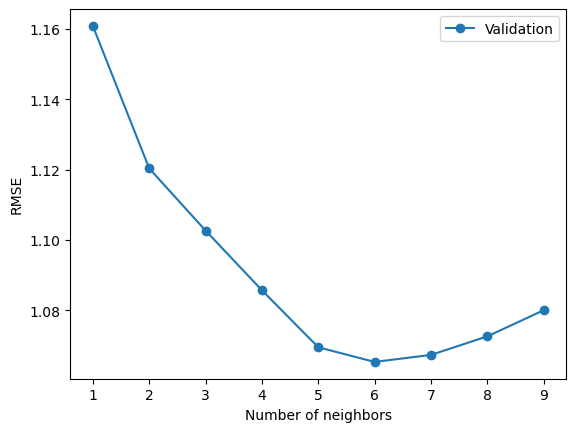

In [29]:
plt.figure()
# plt.plot(n_neighborss, train_rmses, marker="x", label="Train")
plt.plot(n_neighborss, val_rmses, marker="o", label="Validation")
plt.xlabel("Number of neighbors")
plt.ylabel("RMSE")
plt.legend()

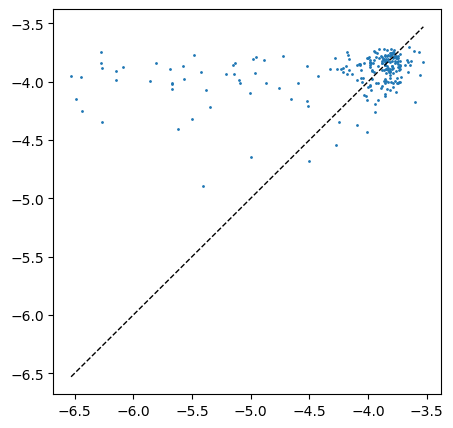

In [36]:
test_preds = knn.predict(test_dset.features)
test_preds = label_scaler.inverse_transform(test_preds)
test_labels = label_scaler.inverse_transform(test_dset.labels)
plt.figure(figsize=(5, 5))
plt.scatter(test_labels, test_preds, s=1)
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], "k--", lw=1)